Link to Medium post:[Let's talk about Signals](https://parmarsuraj99.medium.com/lets-talk-about-signals-841934f24450)

## Libraries and imports

In [ ]:
!pip install numerapi
!pip install yfinance
!pip install simplejson

!pip install catboost

In [ ]:
import gc, os

import numerapi
import yfinance
import simplejson

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import requests
from datetime import datetime
from dateutil.relativedelta import relativedelta, FR

Tickers that Numerai signals want. These are bloomberg tickers. yfinance asks for yahoo finance tickers.

## Data acquisition

In [ ]:
napi = numerapi.SignalsAPI()

eligible_tickers = pd.Series(napi.ticker_universe(), name="bloomberg_ticker")
print(f"Number of eligible tickers : {len(eligible_tickers)}")

print(eligible_tickers.head(10))

Number of eligible tickers : 5130
0    bloomberg_ticker
1              SVW AU
2              GEM AU
3              VOC AU
4              AZJ AU
5              NXT AU
6              TWE AU
7              SGR AU
8              CKF AU
9              BGA AU
Name: bloomberg_ticker, dtype: object


This file has mapping from bloomberg to yahoo finance tickers.
So, we can use yfinance tickers to download and then map/rename them back to bloomberg tickers.

In [ ]:
ticker_map = pd.read_csv(
        'https://numerai-signals-public-data.s3-us-west-2.amazonaws.com/signals_ticker_map_w_bbg.csv'
)
print(len(ticker_map))

ticker_map.head()

#Yahoo <-> Bloomberg mapping
yfinance_tickers = eligible_tickers.map(
        dict(zip(ticker_map["bloomberg_ticker"], ticker_map["yahoo"]))
    ).dropna()

bloomberg_tickers = ticker_map["bloomberg_ticker"]

print(f"Number of eligible, mapped tickers: {len(yfinance_tickers)}")


5031
Number of eligible, mapped tickers: 4894


These are tickers that Numerai signals wants and are also in the mapping dictionary

In [ ]:
def get_prices(tickers, threads=False, n=1000):

    chunk_df = [
            tickers.iloc[i:i+n] 
            for i in range(0, len(tickers), n)
    ]    

    concat_dfs = []

    for chunk in chunk_df:
        try:
            #['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
            
            temp_df = yfinance.download(chunk.str.cat(sep=' '),
                                        start = '2005-12-01',
                                        threads=threads)
            
            #We'll use adjusted close here
            temp_df = temp_df['Adj Close'].stack().reset_index()
            concat_dfs.append(temp_df)

        except:
            pass

    return pd.concat(concat_dfs)

In [ ]:
#this will take some time
full_data = get_prices(yfinance_tickers)

full_df = full_data.copy()
full_df.columns=['date', 'ticker', 'price']
full_df.set_index('date', inplace=True)

full_df['ticker'] = full_df.ticker.map(
    dict(zip(ticker_map["yahoo"], bloomberg_tickers))
)

In [ ]:
full_df.to_csv("full_data.csv")

In [ ]:
#A day's data
full_df.groupby("date").get_group("2005-12-01")

,ticker,price
date,,
2005-12-01,000060 KS,2566.816162
2005-12-01,1 HK,32.761726
2005-12-01,000100 KS,115134.000000
2005-12-01,000120 KS,146178.000000
2005-12-01,000150 KS,23580.773438
...,...,...
2005-12-01,YUM US,13.331914
2005-12-01,ZBH US,59.352768
2005-12-01,ZIOP US,4.600000


In [ ]:
print(f"Number of tickers with data: {len(full_df.ticker.unique())}")

Number of tickers with data: 2877


## Technical Indicators

In [ ]:
def RSI(prices, interval=14):
    '''Computes Relative Strength Index given a price series and lookback interval
    Modified from https://stackoverflow.com/questions/20526414/relative-strength-index-in-python-pandas
    See more here https://www.investopedia.com/terms/r/rsi.asp'''
    delta = prices.diff()

    dUp, dDown = delta.copy(), delta.copy()
    dUp[dUp < 0] = 0
    dDown[dDown > 0] = 0

    RolUp = dUp.rolling(interval).mean()
    RolDown = dDown.rolling(interval).mean().abs()

    RS = RolUp / RolDown
    RSI = 100.0 - (100.0 / (1.0 + RS))
    return RSI

def sma(prices, window=10):

    return (sum(prices, window))/window

In [ ]:
ticker_groups = full_df.groupby('ticker')
full_df["RSI"] = ticker_groups["price"].transform(lambda x: RSI(x))
full_df["SMA_10"] = ticker_groups["price"].transform(lambda x: sma(x, 10))

In [ ]:
#a list of tickers used in full_df.columns to ease the calculation.
indicators = ['RSI', 'SMA_10']

In [ ]:
full_df

,ticker,price,RSI,SMA_10
date,,,,
2005-12-01,000060 KS,2566.816162,NaN,3.867876e+06
2005-12-01,1 HK,32.761726,NaN,2.216600e+04
2005-12-01,000100 KS,115134.000000,NaN,5.563629e+07
2005-12-01,000120 KS,146178.000000,NaN,4.960743e+07
2005-12-01,000150 KS,23580.773438,NaN,3.583611e+07
...,...,...,...,...
2020-11-20,ZNGA US,8.300000,36.997321,9.836530e+02
2020-11-20,ZS US,142.380005,55.569575,4.476743e+03
2020-11-20,ZUMZ US,34.180000,65.934801,9.094905e+03


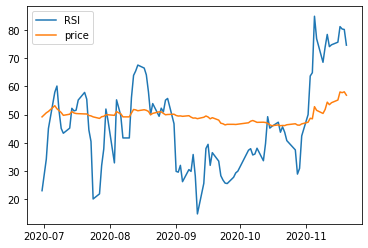

In [ ]:
plt.plot(full_df[full_df['ticker']=="1 HK"]["RSI"][-100:], label='RSI')
plt.plot(full_df[full_df['ticker']=="1 HK"]["price"][-100:], label='price')
plt.legend(loc='upper left')

plt.show()

In [ ]:
%%time

date_groups = full_df.groupby(full_df.index)

for indicator in indicators:
    print(indicator)
    full_df[f"{indicator}_quintile"] = date_groups[indicator].transform(
        lambda group: pd.qcut(group, 5, labels=False, duplicates='drop')
    ).astype(np.float32)
    gc.collect()

RSI
SMA_10
CPU times: user 43.4 s, sys: 263 ms, total: 43.7 s
Wall time: 43.7 s


In [ ]:
full_df.head()

,ticker,price,RSI,SMA_10,RSI_quintile,SMA_10_quintile
date,,,,,,
2005-12-01,000060 KS,2566.816162,NaN,3.867876e+06,NaN,4.0
2005-12-01,1 HK,32.761726,NaN,2.216600e+04,NaN,3.0
2005-12-01,000100 KS,115134.000000,NaN,5.563629e+07,NaN,4.0
2005-12-01,000120 KS,146178.000000,NaN,4.960743e+07,NaN,4.0
2005-12-01,000150 KS,23580.773438,NaN,3.583611e+07,NaN,4.0


Let's encode historical RSI into features

In [ ]:
ticker_groups = full_df.groupby("ticker")

#create lagged features, lag 0 is that day's value, lag 1 is yesterday's value, etc

for indicator in indicators:
    num_days = 5
    for day in range(num_days + 1):
        full_df[f"{indicator}_quintile_lag_{day}"] = ticker_groups[
            f"{indicator}_quintile"
        ].transform(lambda group: group.shift(day))

    gc.collect()


In [ ]:
full_df.tail()

,ticker,price,RSI,SMA_10,RSI_quintile,SMA_10_quintile,RSI_quintile_lag_0,RSI_quintile_lag_1,RSI_quintile_lag_2,RSI_quintile_lag_3,RSI_quintile_lag_4,RSI_quintile_lag_5,SMA_10_quintile_lag_0,SMA_10_quintile_lag_1,SMA_10_quintile_lag_2,SMA_10_quintile_lag_3,SMA_10_quintile_lag_4,SMA_10_quintile_lag_5
date,,,,,,,,,,,,,,,,,,
2020-11-20,ZNGA US,8.300000,36.997321,983.653001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-11-20,ZS US,142.380005,55.569575,4476.743003,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
2020-11-20,ZUMZ US,34.180000,65.934801,9094.904501,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0
2020-11-20,ZUO US,11.590100,88.518959,1128.405010,4.0,0.0,4.0,4.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-11-20,ZYXI US,13.215000,52.935324,766.794547,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# create difference of the lagged features (change in RSI quintile by day)
for indicator in indicators:
    for day in range(num_days):
        full_df[f"{indicator}_diff_{day}"] = (
            full_df[f"{indicator}_quintile_lag_{day}"]
            - full_df[f"{indicator}_quintile_lag_{day + 1}"]
        )
        full_df[f"{indicator}_abs_diff_{day}"] = np.abs(
            full_df[f"{indicator}_quintile_lag_{day}"]
            - full_df[f"{indicator}_quintile_lag_{day + 1}"]
        )

    gc.collect()


In [ ]:
full_df.tail()

,ticker,price,RSI,SMA_10,RSI_quintile,SMA_10_quintile,RSI_quintile_lag_0,RSI_quintile_lag_1,RSI_quintile_lag_2,RSI_quintile_lag_3,RSI_quintile_lag_4,RSI_quintile_lag_5,SMA_10_quintile_lag_0,SMA_10_quintile_lag_1,SMA_10_quintile_lag_2,SMA_10_quintile_lag_3,SMA_10_quintile_lag_4,SMA_10_quintile_lag_5,RSI_diff_0,RSI_abs_diff_0,RSI_diff_1,RSI_abs_diff_1,RSI_diff_2,RSI_abs_diff_2,RSI_diff_3,RSI_abs_diff_3,RSI_diff_4,RSI_abs_diff_4,SMA_10_diff_0,SMA_10_abs_diff_0,SMA_10_diff_1,SMA_10_abs_diff_1,SMA_10_diff_2,SMA_10_abs_diff_2,SMA_10_diff_3,SMA_10_abs_diff_3,SMA_10_diff_4,SMA_10_abs_diff_4
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-11-20,ZNGA US,8.300000,36.997321,983.653001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-11-20,ZS US,142.380005,55.569575,4476.743003,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-11-20,ZUMZ US,34.180000,65.934801,9094.904501,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-11-20,ZUO US,11.590100,88.518959,1128.405010,4.0,0.0,4.0,4.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-11-20,ZYXI US,13.215000,52.935324,766.794547,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
full_df[full_df["ticker"]=="ZEL NZ"]

,ticker,price,RSI,SMA_10,RSI_quintile,SMA_10_quintile,RSI_quintile_lag_0,RSI_quintile_lag_1,RSI_quintile_lag_2,RSI_quintile_lag_3,RSI_quintile_lag_4,RSI_quintile_lag_5,SMA_10_quintile_lag_0,SMA_10_quintile_lag_1,SMA_10_quintile_lag_2,SMA_10_quintile_lag_3,SMA_10_quintile_lag_4,SMA_10_quintile_lag_5,RSI_diff_0,RSI_abs_diff_0,RSI_diff_1,RSI_abs_diff_1,RSI_diff_2,RSI_abs_diff_2,RSI_diff_3,RSI_abs_diff_3,RSI_diff_4,RSI_abs_diff_4,SMA_10_diff_0,SMA_10_abs_diff_0,SMA_10_diff_1,SMA_10_abs_diff_1,SMA_10_diff_2,SMA_10_abs_diff_2,SMA_10_diff_3,SMA_10_abs_diff_3,SMA_10_diff_4,SMA_10_abs_diff_4
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-08-19,ZEL NZ,2.634545,NaN,893.510666,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-08-20,ZEL NZ,2.692130,NaN,893.510666,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-08-21,ZEL NZ,2.728122,NaN,893.510666,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2013-08-22,ZEL NZ,2.720923,NaN,893.510666,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2013-08-23,ZEL NZ,2.713725,NaN,893.510666,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-16,ZEL NZ,3.180000,67.692307,893.510666,3.0,0.0,3.0,3.0,3.0,4.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-11-17,ZEL NZ,3.270000,75.714276,893.510666,3.0,0.0,3.0,3.0,3.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-11-18,ZEL NZ,3.230000,79.104492,893.510666,4.0,0.0,4.0,3.0,3.0,3.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
feature_names = [f for f in full_df.columns for y in ['lag', 'diff'] if y in f]

## Historical Numerai Targets

In [ ]:
TARGET_NAME = "target"
PREDICTION_NAME = "signal"

In [ ]:
url = "https://numerai-signals-public-data.s3-us-west-2.amazonaws.com/signals_train_val.csv"
targets = pd.read_csv(url)
targets.head()

,ticker,friday_date,data_type,target
0,000270 KS,20030131,train,0.50
1,000810 KS,20030131,train,0.50
2,000830 KS,20030131,train,0.50
3,002790 KS,20030131,train,0.25
4,003450 KS,20030131,train,0.25


In [ ]:
targets['date'] = pd.to_datetime(targets['friday_date'], format='%Y%m%d')

In [ ]:
targets[targets["data_type"]=="train"]

,ticker,friday_date,data_type,target,date
0,000270 KS,20030131,train,0.50,2003-01-31
1,000810 KS,20030131,train,0.50,2003-01-31
2,000830 KS,20030131,train,0.50,2003-01-31
3,002790 KS,20030131,train,0.25,2003-01-31
4,003450 KS,20030131,train,0.25,2003-01-31
...,...,...,...,...,...
2170328,ZOLT,20121228,train,0.25,2012-12-28
2170329,ZOT SM,20121228,train,0.50,2012-12-28
2170330,ZQK,20121228,train,1.00,2012-12-28
2170331,ZUMZ,20121228,train,0.75,2012-12-28


In [ ]:
targets[targets["data_type"]=="validation"]

,ticker,friday_date,data_type,target,date
2170333,000030 KS,20130104,validation,0.25,2013-01-04
2170334,000060 KS,20130104,validation,1.00,2013-01-04
2170335,000080 KS,20130104,validation,0.75,2013-01-04
2170336,000100 KS,20130104,validation,0.50,2013-01-04
2170337,000120 KS,20130104,validation,0.75,2013-01-04
...,...,...,...,...,...
4043430,ZTS,20200228,validation,0.50,2020-02-28
4043431,ZUMZ,20200228,validation,1.00,2020-02-28
4043432,ZUO,20200228,validation,0.25,2020-02-28
4043433,ZURN SW,20200228,validation,0.25,2020-02-28


In [ ]:
targets.target.value_counts()

0.50    2024820
0.25     807654
0.75     807475
1.00     201771
0.00     201715
Name: target, dtype: int64

In [ ]:
ML_data = pd.merge(full_df.reset_index(), targets,
         on=["date", "ticker"]).set_index("date")

ML_data.dropna(inplace=True)
ML_data = ML_data[ML_data.index.weekday==4]
ML_data = ML_data[ML_data.index.value_counts() > 200]

gc.collect()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


24

In [ ]:
print(f'Number of eras in data: {len(ML_data.index.unique())}')

Number of eras in data: 633


In [ ]:
ML_data

,ticker,price,RSI,SMA_10,RSI_quintile,SMA_10_quintile,RSI_quintile_lag_0,RSI_quintile_lag_1,RSI_quintile_lag_2,RSI_quintile_lag_3,RSI_quintile_lag_4,RSI_quintile_lag_5,SMA_10_quintile_lag_0,SMA_10_quintile_lag_1,SMA_10_quintile_lag_2,SMA_10_quintile_lag_3,SMA_10_quintile_lag_4,SMA_10_quintile_lag_5,RSI_diff_0,RSI_abs_diff_0,RSI_diff_1,RSI_abs_diff_1,RSI_diff_2,RSI_abs_diff_2,RSI_diff_3,RSI_abs_diff_3,RSI_diff_4,RSI_abs_diff_4,SMA_10_diff_0,SMA_10_abs_diff_0,SMA_10_diff_1,SMA_10_abs_diff_1,SMA_10_diff_2,SMA_10_abs_diff_2,SMA_10_diff_3,SMA_10_abs_diff_3,SMA_10_diff_4,SMA_10_abs_diff_4,friday_date,data_type,target
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-04-20,000060 KS,4706.549316,57.608656,3.867876e+06,1.0,4.0,1.0,3.0,3.0,2.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,-2.0,2.0,0.0,0.0,1.0,1.0,-1.0,1.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20070420,train,0.75
2007-04-20,1 HK,42.081696,63.043641,2.216600e+04,2.0,3.0,2.0,2.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20070420,train,0.50
2007-04-20,000100 KS,104913.000000,65.753367,5.563629e+07,3.0,4.0,3.0,2.0,2.0,2.0,1.0,1.0,4.0,4.0,4.0,4.0,4.0,4.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20070420,train,0.75
2007-04-20,000150 KS,70944.570312,65.269503,3.583611e+07,2.0,4.0,2.0,3.0,2.0,2.0,2.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,-1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20070420,train,0.25
2007-04-20,2 HK,32.508465,58.791155,1.859310e+04,2.0,3.0,2.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20070420,train,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-28,WPL AU,27.419003,16.839702,9.821517e+03,0.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20200228,validation,0.50
2020-02-28,WSA AU,2.397950,42.857143,1.327534e+03,4.0,0.0,4.0,4.0,3.0,3.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20200228,validation,0.50
2020-02-28,WTC AU,15.075290,14.568054,1.857207e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20200228,validation,0.25


In [ ]:
gc.collect()

12

## Modelling

In [ ]:
train_data = ML_data[ML_data['data_type'] == 'train']
test_data = ML_data[ML_data['data_type'] == 'validation']
gc.collect()

0

In [ ]:
feature_names = [f for f in train_data.columns for y in ['lag', 'diff'] if y in f]

In [ ]:
from catboost import CatBoost

In [ ]:
params = {
    "objective":"RMSE",
    "iterations":1000,
    "task_type":"GPU"
}
model = CatBoost(params)

In [ ]:
gc.collect()

model.fit(train_data[feature_names], 
          train_data[TARGET_NAME],
          eval_set = (test_data[feature_names], 
          test_data[TARGET_NAME]))

gc.collect()

Learning rate set to 0.087778
0:	learn: 0.2335388	test: 0.2312712	best: 0.2312712 (0)	total: 8.29ms	remaining: 8.28s
1:	learn: 0.2335202	test: 0.2312720	best: 0.2312712 (0)	total: 15.2ms	remaining: 7.6s
2:	learn: 0.2335128	test: 0.2312723	best: 0.2312712 (0)	total: 22.1ms	remaining: 7.33s
3:	learn: 0.2335035	test: 0.2312726	best: 0.2312712 (0)	total: 29ms	remaining: 7.21s
4:	learn: 0.2334935	test: 0.2312730	best: 0.2312712 (0)	total: 35.9ms	remaining: 7.15s
5:	learn: 0.2334849	test: 0.2312732	best: 0.2312712 (0)	total: 43.1ms	remaining: 7.14s
6:	learn: 0.2334778	test: 0.2312736	best: 0.2312712 (0)	total: 50ms	remaining: 7.1s
7:	learn: 0.2334622	test: 0.2312733	best: 0.2312712 (0)	total: 56.7ms	remaining: 7.03s
8:	learn: 0.2334540	test: 0.2312745	best: 0.2312712 (0)	total: 63.3ms	remaining: 6.97s
9:	learn: 0.2334536	test: 0.2312750	best: 0.2312712 (0)	total: 67.8ms	remaining: 6.72s
10:	learn: 0.2334409	test: 0.2312761	best: 0.2312712 (0)	total: 74.4ms	remaining: 6.69s
11:	learn: 0.23343

0

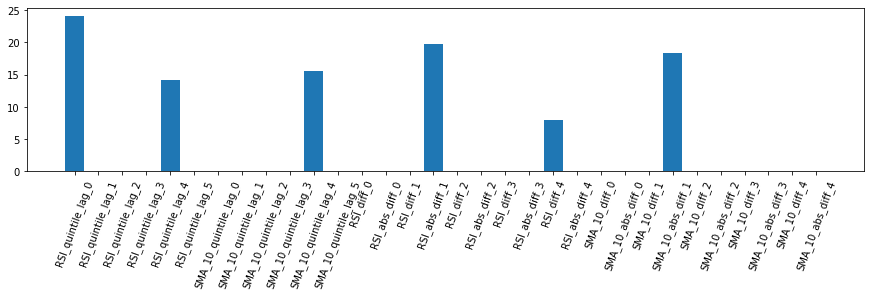

In [ ]:
plt.figure(figsize=(15,3))
plt.bar(feature_names, model.feature_importances_)
plt.xticks(rotation=70)
plt.show()

## Evaluation on historic data

In [ ]:
train_data[PREDICTION_NAME] = model.predict(train_data[feature_names])
test_data[PREDICTION_NAME] = model.predict(test_data[feature_names])

#show prediction distribution, most should around the center
test_data[PREDICTION_NAME].hist(bins=30)

In [ ]:
#From Jason Rosenfeld's notebook
#https://twitter.com/jrosenfeld13/status/1315749231387443202?s=20

def score(df):
    '''Takes df and calculates spearm correlation from pre-defined cols'''
    # method="first" breaks ties based on order in array
    return np.corrcoef(
        df[TARGET_NAME],
        df[PREDICTION_NAME].rank(pct=True, method="first")
    )[0,1]

def run_analytics(era_scores):
    print(f"Mean Correlation: {era_scores.mean():.4f}")
    print(f"Median Correlation: {era_scores.median():.4f}")
    print(f"Standard Deviation: {era_scores.std():.4f}")
    print('\n')
    print(f"Mean Pseudo-Sharpe: {era_scores.mean()/era_scores.std():.4f}")
    print(f"Median Pseudo-Sharpe: {era_scores.median()/era_scores.std():.4f}")
    print('\n')
    print(f'Hit Rate (% positive eras): {era_scores.apply(lambda x: np.sign(x)).value_counts()[1]/len(era_scores):.2%}')

    era_scores.rolling(10).mean().plot(kind='line', title='Rolling Per Era Correlation Mean', figsize=(15,4))
    plt.axhline(y=0.0, color="r", linestyle="--"); plt.show()

    era_scores.cumsum().plot(title='Cumulative Sum of Era Scores', figsize=(15,4))
    plt.axhline(y=0.0, color="r", linestyle="--"); plt.show()

In [ ]:
# spearman scores by era
train_era_scores = train_data.groupby(train_data.index).apply(score)
test_era_scores = test_data.groupby(test_data.index).apply(score)

Mean Correlation: 0.0168
Median Correlation: 0.0161
Standard Deviation: 0.0686


Mean Pseudo-Sharpe: 0.2441
Median Pseudo-Sharpe: 0.2346


Hit Rate (% positive eras): 57.25%


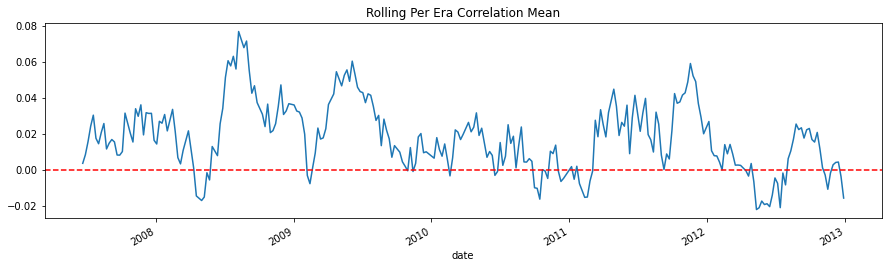

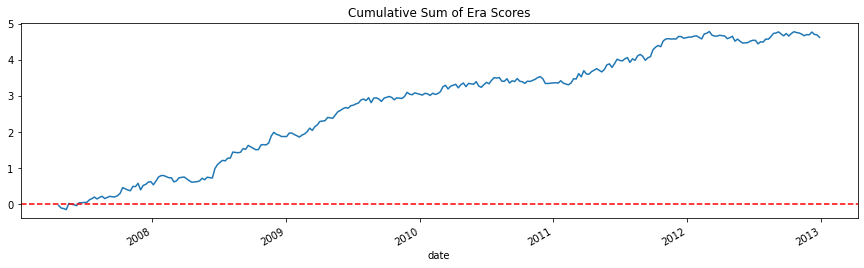

In [ ]:
#train scores, in-sample and will be significantly overfit
run_analytics(train_era_scores)

Mean Correlation: 0.0051
Median Correlation: 0.0050
Standard Deviation: 0.0560


Mean Pseudo-Sharpe: 0.0905
Median Pseudo-Sharpe: 0.0900


Hit Rate (% positive eras): 52.94%


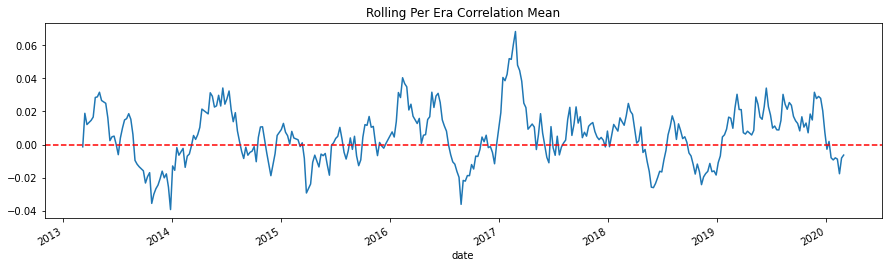

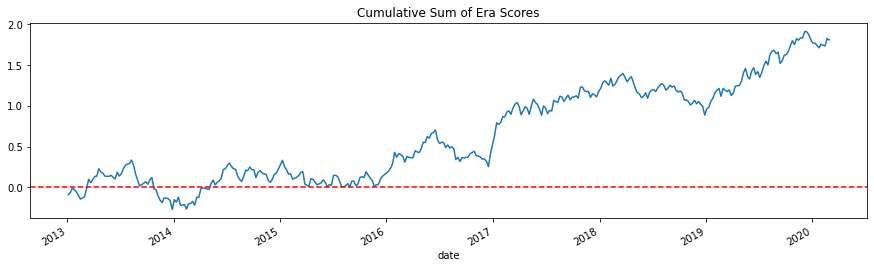

In [ ]:
#test scores, out of sample
run_analytics(test_era_scores)

## Prediction on live data

In [ ]:
# choose data as of most recent friday
last_friday = datetime.now() + relativedelta(weekday=FR(-1))
date_string = last_friday.strftime('%Y-%m-%d')

live_data = full_df.loc[date_string].copy()
live_data.dropna(subset=feature_names, inplace=True)

In [ ]:
live_data

,ticker,price,RSI,SMA_10,RSI_quintile,SMA_10_quintile,RSI_quintile_lag_0,RSI_quintile_lag_1,RSI_quintile_lag_2,RSI_quintile_lag_3,RSI_quintile_lag_4,RSI_quintile_lag_5,SMA_10_quintile_lag_0,SMA_10_quintile_lag_1,SMA_10_quintile_lag_2,SMA_10_quintile_lag_3,SMA_10_quintile_lag_4,SMA_10_quintile_lag_5,RSI_diff_0,RSI_abs_diff_0,RSI_diff_1,RSI_abs_diff_1,RSI_diff_2,RSI_abs_diff_2,RSI_diff_3,RSI_abs_diff_3,RSI_diff_4,RSI_abs_diff_4,SMA_10_diff_0,SMA_10_abs_diff_0,SMA_10_diff_1,SMA_10_abs_diff_1,SMA_10_diff_2,SMA_10_abs_diff_2,SMA_10_diff_3,SMA_10_abs_diff_3,SMA_10_diff_4,SMA_10_abs_diff_4
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-11-20,000060 KS,15300.000000,61.764706,3.867876e+06,1.0,4.0,1.0,2.0,1.0,0.0,1.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,-1.0,1.0,1.0,1.0,1.0,1.0,-1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-11-20,000080 KS,33700.000000,50.458716,6.195700e+06,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-11-20,1 HK,56.849998,74.550126,2.216600e+04,3.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-11-20,000100 KS,66000.000000,74.766355,5.563629e+07,3.0,4.0,3.0,3.0,2.0,1.0,3.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,1.0,1.0,1.0,1.0,-2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-11-20,000120 KS,169500.000000,59.770115,4.960743e+07,1.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-20,ZNGA US,8.300000,36.997321,9.836530e+02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-11-20,ZS US,142.380005,55.569575,4.476743e+03,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-11-20,ZUMZ US,34.180000,65.934801,9.094905e+03,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print(f"Number of live tickers to submit: {len(live_data)}")
live_data[PREDICTION_NAME] = model.predict(live_data[feature_names])

Number of live tickers to submit: 2783


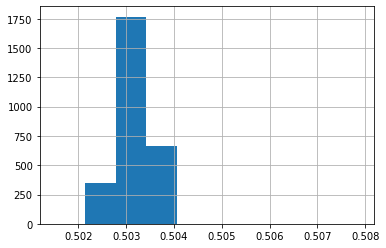

In [ ]:
live_data[PREDICTION_NAME].hist()

You can simply run this without any modification

In [ ]:
diagnostic_df = pd.concat([test_data, live_data])
diagnostic_df['friday_date'] = diagnostic_df.friday_date.fillna(
    last_friday.strftime('%Y%m%d')).astype(int)
diagnostic_df['data_type'] = diagnostic_df.data_type.fillna('live')
diagnostic_df[['ticker', 'friday_date', 'data_type',
                'signal']].reset_index(drop=True).to_csv(
    'example_signal_upload.csv', index=False)
print(
    'Example submission completed. Upload to signals.numer.ai for scores and live submission'
)

Example submission completed. Upload to signals.numer.ai for scores and live submission


In [ ]:
diagnostic_df

,ticker,price,RSI,SMA_10,RSI_quintile,SMA_10_quintile,RSI_quintile_lag_0,RSI_quintile_lag_1,RSI_quintile_lag_2,RSI_quintile_lag_3,RSI_quintile_lag_4,RSI_quintile_lag_5,SMA_10_quintile_lag_0,SMA_10_quintile_lag_1,SMA_10_quintile_lag_2,SMA_10_quintile_lag_3,SMA_10_quintile_lag_4,SMA_10_quintile_lag_5,RSI_diff_0,RSI_abs_diff_0,RSI_diff_1,RSI_abs_diff_1,RSI_diff_2,RSI_abs_diff_2,RSI_diff_3,RSI_abs_diff_3,RSI_diff_4,RSI_abs_diff_4,SMA_10_diff_0,SMA_10_abs_diff_0,SMA_10_diff_1,SMA_10_abs_diff_1,SMA_10_diff_2,SMA_10_abs_diff_2,SMA_10_diff_3,SMA_10_abs_diff_3,SMA_10_diff_4,SMA_10_abs_diff_4,friday_date,data_type,target,signal
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-04,000060 KS,10106.674805,48.421082,3.867876e+06,0.0,4.0,0.0,0.0,0.0,3.0,3.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,-3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20130104,validation,1.00,0.503507
2013-01-04,000080 KS,25759.785156,74.043700,6.195700e+06,3.0,4.0,3.0,4.0,4.0,2.0,3.0,2.0,4.0,4.0,4.0,4.0,4.0,4.0,-1.0,1.0,0.0,0.0,2.0,2.0,-1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20130104,validation,0.75,0.503507
2013-01-04,1 HK,62.570312,57.594768,2.216600e+04,1.0,3.0,1.0,1.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20130104,validation,0.50,0.503313
2013-01-04,000100 KS,149320.000000,62.590293,5.563629e+07,2.0,4.0,2.0,1.0,1.0,1.0,2.0,1.0,4.0,4.0,4.0,4.0,4.0,4.0,1.0,1.0,0.0,0.0,0.0,0.0,-1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20130104,validation,0.50,0.503507
2013-01-04,000120 KS,107500.000000,58.566978,4.960743e+07,1.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,4.0,4.0,4.0,4.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20130104,validation,0.75,0.503388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-20,ZNGA US,8.300000,36.997321,9.836530e+02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20201120,live,NaN,0.503702
2020-11-20,ZS US,142.380005,55.569575,4.476743e+03,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20201120,live,NaN,0.503702
2020-11-20,ZUMZ US,34.180000,65.934801,9.094905e+03,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20201120,live,NaN,0.503288


In [ ]:
ps = diagnostic_df.groupby('date')[PREDICTION_NAME].rank(pct=True, method="first")

In [ ]:
diagnostic_df["signal"] = ps

In [ ]:
diagnostic_df[["ticker", "friday_date", "data_type", "signal"]].reset_index(
    drop=True
).to_csv("example_signal_upload.csv", index=False)

print("Upload to signals.numer.ai for scores and live submission")

Upload to signals.numer.ai for scores and live submission


## Uploading predictions using your API keys 🚀

Find your Numerapi public and private keys from https://numer.ai/account

To create a key for submission only, 

`Settings -> Create API key -> select "Upload Predictions" -> Save`


In [ ]:
# NameOfYourAI
# Add keys between the quotes
public_id = "7TISUDGAWEVO2B35ECOQQXU2RWXGZN3I"
secret_key = "QJYUWIMFEEDNZ4GHUO6VSSKPMRCBFJIMJ7BZ65ESIWRN4YHGYHSRJDNL64TAG7EH"
model_id = "d49c26a4-aa5b-4490-9d58-300c5e05d996"
napi = numerapi.SignalsAPI(public_id=public_id, secret_key=secret_key)

In [ ]:
submission_id = napi.upload_predictions(f"/content/example_signal_upload.csv", model_id=model_id)

And its done. Congratulations🎉. Your predictions for latest round are submitted! 


Check some information about your latest predictions on [Signals Tournament]
(https://signals.numer.ai/tournament). It will show some metrics like this,


![sign.png](https://cdn-images-1.medium.com/max/600/1*hTpX_ArF2DmPHRppVeM9Ig.png)




# About

Last updated: 2020-11-20

Created by: Suraj Parmar

- Numerai: [surajp](https://numer.ai/surajp)

- Twitter: [@parmarsuraj99](https://twitter.com/parmarsuraj99)